In [ ]:
# ============================================================================
# MOD002691 - FINAL PROJECT: RESNET-50 TRAINING
# ============================================================================
#
# Author:       Oriol Morros Vilaseca (SID: 2270056)
# Supervisor:   Mr Vitaliy Milke
# Institution:  Anglia Ruskin University, Cambridge
# Module:       MOD002691 - Final Project (BSc Software Engineering)
# Date:         January 2026
#
# ============================================================================
# PURPOSE
# ============================================================================
#
# Train a ResNet-50 model using transfer learning from ImageNet.
# This is Model 3 of 3 in a comparative study:
#
#   1. Custom CNN (baseline, trained from scratch)
#   2. EfficientNetB0 (transfer learning)
#   3. ResNet-50 (transfer learning) <- This notebook
#
# ============================================================================
# FAIR COMPARISON CONTROLS
# ============================================================================
#
# To ensure valid comparison, ALL models use IDENTICAL:
#   - Dataset (same train/val/test split, SHA-256 verified zero leakage)
#   - Image size (224x224 RGB)
#   - Batch size (32)
#   - Data augmentation pipeline
#   - Class weights (to handle 113:1 imbalance)
#   - Callbacks (EarlyStopping, ReduceLROnPlateau, ModelCheckpoint)
#   - Evaluation metrics and methodology
#
# The ONLY difference is the model architecture itself.
#
# ============================================================================

In [ ]:
# ============================================================================
# CELL 2: ENVIRONMENT SETUP
# ============================================================================
# Displays runtime information for reproducibility documentation.
# ============================================================================

import sys
import platform
from datetime import datetime

print("=" * 70)
print("RESNET-50 TRAINING")
print("=" * 70)
print(f"Execution:  {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Python:     {sys.version.split()[0]}")
print(f"Platform:   {platform.platform()}")
print("=" * 70)

RESNET-50 TRAINING
Execution:  2026-01-25 12:56:15
Python:     3.12.12
Platform:   Linux-6.6.105+-x86_64-with-glibc2.35


In [ ]:
# ============================================================================
# CELL 3: IMPORTS AND GPU CONFIGURATION
# ============================================================================
# Core ML libraries. GPU memory growth enabled to prevent OOM errors.
# ============================================================================

import os
import json
import shutil
import zipfile
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from collections import defaultdict

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from google.colab import drive
drive.mount('/content/drive')

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# GPU Configuration
print("=" * 70)
print("HARDWARE CONFIGURATION")
print("=" * 70)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU Available: Yes")
    print(f"GPU Device:    {gpus[0].name}")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("GPU Available: No (training will be slow)")

print(f"TensorFlow:    {tf.__version__}")
print(f"Random Seed:   {SEED}")

Mounted at /content/drive
HARDWARE CONFIGURATION
GPU Available: Yes
GPU Device:    /physical_device:GPU:0
TensorFlow:    2.19.0
Random Seed:   42


In [ ]:
# ============================================================================
# CELL 4: SHARED CONFIGURATION
# ============================================================================
# These parameters are IDENTICAL across all three model notebooks.
# This ensures a fair and valid comparison between architectures.
# ============================================================================

print("=" * 70)
print("TRAINING CONFIGURATION")
print("=" * 70)

# Dataset paths (use your NEW cleaned dataset)
DATASET_ZIP = "/content/drive/MyDrive/snapshelf_final_dataset/snapshelf_dataset_14classes_deduped.zip"
LOCAL_DATASET = "/content/snapshelf_dataset"
DRIVE_MODEL_DIR = "/content/drive/MyDrive/snapshelf_models_v2"

# Image and batch configuration (IDENTICAL for all models)
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 14

# Training configuration (IDENTICAL for all models)
MAX_EPOCHS = 50
EARLY_STOPPING_PATIENCE = 7
REDUCE_LR_PATIENCE = 3
REDUCE_LR_FACTOR = 0.5
MIN_LR = 1e-7

# Data augmentation configuration (IDENTICAL for all models)
AUGMENTATION_CONFIG = {
    'rotation_range': 20,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1,
    'shear_range': 0.1,
    'zoom_range': 0.1,
    'horizontal_flip': True,
    'fill_mode': 'nearest'
}

print(f"""
[Dataset]
  Source: {DATASET_ZIP}

[Image Configuration]
  Size:       {IMG_SIZE[0]}x{IMG_SIZE[1]} pixels
  Batch Size: {BATCH_SIZE}
  Classes:    {NUM_CLASSES}

[Training Configuration]
  Max Epochs:    {MAX_EPOCHS}
  Early Stop:    {EARLY_STOPPING_PATIENCE} epochs patience
  LR Reduction:  factor={REDUCE_LR_FACTOR}, patience={REDUCE_LR_PATIENCE}

[Data Augmentation]
  Rotation:        {AUGMENTATION_CONFIG['rotation_range']} degrees
  Width Shift:     {AUGMENTATION_CONFIG['width_shift_range']}
  Height Shift:    {AUGMENTATION_CONFIG['height_shift_range']}
  Shear:           {AUGMENTATION_CONFIG['shear_range']}
  Zoom:            {AUGMENTATION_CONFIG['zoom_range']}
  Horizontal Flip: {AUGMENTATION_CONFIG['horizontal_flip']}
""")

TRAINING CONFIGURATION

[Dataset]
  Source: /content/drive/MyDrive/snapshelf_final_dataset/snapshelf_dataset_14classes_deduped.zip

[Image Configuration]
  Size:       224x224 pixels
  Batch Size: 32
  Classes:    14

[Training Configuration]
  Max Epochs:    50
  Early Stop:    7 epochs patience
  LR Reduction:  factor=0.5, patience=3

[Data Augmentation]
  Rotation:        20 degrees
  Width Shift:     0.1
  Height Shift:    0.1
  Shear:           0.1
  Zoom:            0.1
  Horizontal Flip: True



In [ ]:
# ============================================================================
# CELL 5: LOAD AND EXTRACT DATASET
# ============================================================================
# Extracts the deduplicated dataset prepared in the Dataset Preparation notebook.
# ============================================================================

print("=" * 70)
print("LOADING DATASET")
print("=" * 70)

if not os.path.exists(DATASET_ZIP):
    raise FileNotFoundError(f"Dataset not found: {DATASET_ZIP}")

zip_size_mb = os.path.getsize(DATASET_ZIP) / (1024 * 1024)
print(f"\nDataset: {DATASET_ZIP}")
print(f"Size:    {zip_size_mb:.1f} MB")

# Extract dataset
print(f"\nExtracting to: {LOCAL_DATASET}")
if os.path.exists(LOCAL_DATASET):
    shutil.rmtree(LOCAL_DATASET)

with zipfile.ZipFile(DATASET_ZIP, 'r') as zip_ref:
    zip_ref.extractall(LOCAL_DATASET)
print("Extraction complete.")

# Define paths
TRAIN_DIR = f"{LOCAL_DATASET}/train"
VAL_DIR = f"{LOCAL_DATASET}/val"
TEST_DIR = f"{LOCAL_DATASET}/test"

# Verify structure
print(f"\n[Dataset Structure]")
for split_name, split_dir in [("Train", TRAIN_DIR), ("Val", VAL_DIR), ("Test", TEST_DIR)]:
    if os.path.exists(split_dir):
        n_classes = len([d for d in os.listdir(split_dir) if os.path.isdir(os.path.join(split_dir, d))])
        n_images = sum(len(files) for _, _, files in os.walk(split_dir))
        print(f"  {split_name + ':':<8} {n_classes} classes, {n_images:,} images")
    else:
        raise FileNotFoundError(f"{split_name} directory not found: {split_dir}")

# Get class names
CLASS_NAMES = sorted([d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))])
print(f"\nClasses: {CLASS_NAMES}")

LOADING DATASET

Dataset: /content/drive/MyDrive/snapshelf_final_dataset/snapshelf_dataset_14classes_deduped.zip
Size:    2199.9 MB

Extracting to: /content/snapshelf_dataset
Extraction complete.

[Dataset Structure]
  Train:   14 classes, 84,582 images
  Val:     14 classes, 18,119 images
  Test:    14 classes, 18,141 images

Classes: ['apple', 'banana', 'bell_pepper_green', 'bell_pepper_red', 'carrot', 'cucumber', 'grape', 'lemon', 'onion', 'orange', 'peach', 'potato', 'strawberry', 'tomato']


In [ ]:
# ============================================================================
# CELL 6: DATA GENERATORS WITH CLASS WEIGHTS
# ============================================================================
# Creates data generators with IDENTICAL augmentation settings.
# Computes class weights to address the 113:1 class imbalance.
# ============================================================================

print("=" * 70)
print("DATA GENERATORS")
print("=" * 70)

# Training generator with augmentation and ResNet preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    **AUGMENTATION_CONFIG
)

# Validation and test generators (no augmentation, only preprocessing)
val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Create generators
print("\nCreating generators...")

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

val_generator = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"\n[Generator Summary]")
print(f"  Train:      {train_generator.samples:,} images")
print(f"  Validation: {val_generator.samples:,} images")
print(f"  Test:       {test_generator.samples:,} images")

# Compute class weights to handle imbalance
print(f"\n[Class Weights]")
train_labels = train_generator.classes
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
CLASS_WEIGHTS = dict(enumerate(class_weights_array))

# Display imbalance info
class_counts = np.bincount(train_labels)
max_class = CLASS_NAMES[np.argmax(class_counts)]
min_class = CLASS_NAMES[np.argmin(class_counts)]
imbalance_ratio = np.max(class_counts) / np.min(class_counts)

print(f"  Largest:  {max_class} ({np.max(class_counts):,} samples, weight={CLASS_WEIGHTS[np.argmax(class_counts)]:.4f})")
print(f"  Smallest: {min_class} ({np.min(class_counts):,} samples, weight={CLASS_WEIGHTS[np.argmin(class_counts)]:.4f})")
print(f"  Imbalance Ratio: {imbalance_ratio:.1f}:1")
print(f"\n  Class weights will be applied during training.")

DATA GENERATORS

Creating generators...
Found 84582 images belonging to 14 classes.
Found 18119 images belonging to 14 classes.
Found 18141 images belonging to 14 classes.

[Generator Summary]
  Train:      84,582 images
  Validation: 18,119 images
  Test:       18,141 images

[Class Weights]
  Largest:  apple (31,818 samples, weight=0.1899)
  Smallest: carrot (281 samples, weight=21.5003)
  Imbalance Ratio: 113.2:1

  Class weights will be applied during training.


In [ ]:
# ============================================================================
# CELL 7: BUILD RESNET-50 MODEL
# ============================================================================
# ResNet-50 transfer learning architecture:
#   - Pre-trained base from ImageNet (frozen initially)
#   - Custom classification head with dense layer
#   - Two-phase training: head only, then fine-tune top layers
# ============================================================================

print("=" * 70)
print("BUILDING MODEL: RESNET-50")
print("=" * 70)

# Load pre-trained ResNet-50
print("\nLoading ResNet-50 pre-trained on ImageNet...")
base_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

# Freeze base model initially
base_model.trainable = False

print(f"Base model: {base_model.name}")
print(f"Layers:     {len(base_model.layers)}")

# Build complete model
model = models.Sequential([
    layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    base_model,
    layers.GlobalAveragePooling2D(name='gap'),
    layers.BatchNormalization(name='bn1'),
    layers.Dropout(0.3, name='dropout1'),
    layers.Dense(256, activation='relu', name='fc'),
    layers.BatchNormalization(name='bn2'),
    layers.Dropout(0.3, name='dropout2'),
    layers.Dense(NUM_CLASSES, activation='softmax', name='output')
], name='SnapShelf_ResNet50')

# Compile for Phase 1 (frozen base)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
print("\n[Model Architecture]")
print("-" * 70)
model.summary()

# Parameter count
total_params = model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
non_trainable_params = total_params - trainable_params

print("-" * 70)
print(f"\n[Parameters]")
print(f"  Total:         {total_params:,}")
print(f"  Trainable:     {trainable_params:,}")
print(f"  Non-trainable: {non_trainable_params:,}")

BUILDING MODEL: RESNET-50

Loading ResNet-50 pre-trained on ImageNet...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Base model: resnet50
Layers:     175

[Model Architecture]
----------------------------------------------------------------------


Model: "SnapShelf_ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 2048)           │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc (Dense)                      │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 14)             │         3,598 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,125,070 (92.03 MB)

 Trainable params: 532,750 (2.03 MB)

 Non-trainable params: 23,592,320 (90.00 MB)

----------------------------------------------------------------------

[Parameters]
  Total:         24,125,070
  Trainable:     532,750
  Non-trainable: 23,592,320


In [ ]:
# ============================================================================
# CELL 8: TRAINING CALLBACKS
# ============================================================================
# Callbacks are IDENTICAL across all models for fair comparison.
# ============================================================================

print("=" * 70)
print("TRAINING CALLBACKS")
print("=" * 70)

CHECKPOINT_DIR = "/content/model_checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
BEST_MODEL_PATH = f"{CHECKPOINT_DIR}/best_resnet50.keras"

callback_list = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=EARLY_STOPPING_PATIENCE,
        verbose=1,
        restore_best_weights=True
    ),
    callbacks.ModelCheckpoint(
        filepath=BEST_MODEL_PATH,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=REDUCE_LR_FACTOR,
        patience=REDUCE_LR_PATIENCE,
        min_lr=MIN_LR,
        verbose=1
    )
]

print(f"""
[Callbacks Configured]
  EarlyStopping:     monitor='val_loss', patience={EARLY_STOPPING_PATIENCE}
  ModelCheckpoint:   monitor='val_accuracy', save_best_only=True
  ReduceLROnPlateau: factor={REDUCE_LR_FACTOR}, patience={REDUCE_LR_PATIENCE}, min_lr={MIN_LR}

[Checkpoint Path]
  {BEST_MODEL_PATH}
""")

TRAINING CALLBACKS

[Callbacks Configured]
  EarlyStopping:     monitor='val_loss', patience=7
  ModelCheckpoint:   monitor='val_accuracy', save_best_only=True
  ReduceLROnPlateau: factor=0.5, patience=3, min_lr=1e-07

[Checkpoint Path]
  /content/model_checkpoints/best_resnet50.keras



In [ ]:
# ============================================================================
# CELL 9: PHASE 1 TRAINING (FROZEN BASE)
# ============================================================================
# Train only the classification head while base model is frozen.
# This allows the head to adapt to our data before fine-tuning.
# ============================================================================

print("=" * 70)
print("PHASE 1: TRAINING CLASSIFICATION HEAD")
print("=" * 70)

print(f"\nBase model frozen, training only custom head...")
print(f"Training samples:   {train_generator.samples:,}")
print(f"Validation samples: {val_generator.samples:,}")
print(f"Using class weights: Yes")
print(f"\nStarting at: {datetime.now().strftime('%H:%M:%S')}")
print("-" * 70)

training_start = datetime.now()

history_phase1 = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=callback_list,
    class_weight=CLASS_WEIGHTS,
    verbose=1
)

phase1_end = datetime.now()
phase1_duration = phase1_end - training_start

print("-" * 70)
print(f"Phase 1 completed: {phase1_duration}")
print(f"Phase 1 epochs: {len(history_phase1.history['loss'])}")

PHASE 1: TRAINING CLASSIFICATION HEAD

Base model frozen, training only custom head...
Training samples:   84,582
Validation samples: 18,119
Using class weights: Yes

Starting at: 12:57:46
----------------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
2644/2644 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.8720 - loss: 0.2848
Epoch 1: val_accuracy improved from -inf to 0.98720, saving model to /content/model_checkpoints/best_resnet50.keras
2644/2644 ━━━━━━━━━━━━━━━━━━━━ 966s 360ms/step - accuracy: 0.8720 - loss: 0.2848 - val_accuracy: 0.9872 - val_loss: 0.0505 - learning_rate: 0.0010
Epoch 2/10
2644/2644 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.9692 - loss: 0.0536
Epoch 2: val_accuracy improved from 0.98720 to 0.98902, saving model to /content/model_checkpoints/best_resnet50.keras
2644/2644 ━━━━━━━━━━━━━━━━━━━━ 926s 350ms/step - accuracy: 0.9692 - loss: 0.0536 - val_accuracy: 0.9890 - val_loss: 0.0459 - learning_rate: 0.0010
Epoch 3/10
2644/2644 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.9727 - loss: 0.0505
Epoch 3: val_accuracy did not improve from 0.98902
2644/2644 ━━━━━━━━━━━━━━━━━━━━ 922s 349ms/step - accuracy: 0.9727 - loss: 0.0505 - val_accuracy: 0.9881 - val_loss: 0.0420 - learning_rate: 0.0010
Epo

In [ ]:
# ============================================================================
# CELL 10: PHASE 2 TRAINING (FINE-TUNING)
# ============================================================================
# Unfreeze top 20% of base model layers and continue training
# with a lower learning rate to fine-tune pretrained features.
# ============================================================================

print("=" * 70)
print("PHASE 2: FINE-TUNING TOP LAYERS")
print("=" * 70)

# Unfreeze top 20% of base model layers
base_model.trainable = True
fine_tune_from = int(len(base_model.layers) * 0.8)
for layer in base_model.layers[:fine_tune_from]:
    layer.trainable = False

trainable_layers = sum(1 for layer in base_model.layers if layer.trainable)
print(f"\nFine-tuning {trainable_layers} of {len(base_model.layers)} base layers")
print(f"Layers frozen: {fine_tune_from}")

# Recompile with lower learning rate
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Update trainable params count
trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
print(f"Trainable parameters: {trainable_params:,}")

print(f"\nStarting at: {datetime.now().strftime('%H:%M:%S')}")
print("-" * 70)

history_phase2 = model.fit(
    train_generator,
    epochs=MAX_EPOCHS,
    initial_epoch=len(history_phase1.history['loss']),
    validation_data=val_generator,
    callbacks=callback_list,
    class_weight=CLASS_WEIGHTS,
    verbose=1
)

training_end = datetime.now()
training_duration = training_end - training_start
TRAINING_TIME_SECONDS = training_duration.total_seconds()

print("-" * 70)
print(f"Phase 2 completed at: {training_end.strftime('%H:%M:%S')}")
print(f"Phase 2 epochs: {len(history_phase2.history['loss'])}")
print(f"Total training time: {training_duration}")

# Combine histories
history = {}
for key in history_phase1.history.keys():
    history[key] = history_phase1.history[key] + history_phase2.history[key]

PHASE 2: FINE-TUNING TOP LAYERS

Fine-tuning 35 of 175 base layers
Layers frozen: 140
Trainable parameters: 15,510,798

Starting at: 15:32:46
----------------------------------------------------------------------
Epoch 11/50
2644/2644 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.9680 - loss: 0.0703
Epoch 11: val_accuracy did not improve from 0.99382
2644/2644 ━━━━━━━━━━━━━━━━━━━━ 953s 352ms/step - accuracy: 0.9680 - loss: 0.0703 - val_accuracy: 0.9925 - val_loss: 0.0226 - learning_rate: 1.0000e-04
Epoch 12/50
2644/2644 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.9856 - loss: 0.0236
Epoch 12: val_accuracy did not improve from 0.99382
2644/2644 ━━━━━━━━━━━━━━━━━━━━ 912s 345ms/step - accuracy: 0.9856 - loss: 0.0236 - val_accuracy: 0.9928 - val_loss: 0.0229 - learning_rate: 1.0000e-04
Epoch 13/50
2644/2644 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.9891 - loss: 0.0164
Epoch 13: val_accuracy did not improve from 0.99382
2644/2644 ━━━━━━━━━━━━━━━━━━━━ 911s 344ms/step - accurac

In [ ]:
# ============================================================================
# CELL 11: TEST SET EVALUATION
# ============================================================================
# Final evaluation using the best saved model.
# ============================================================================

print("=" * 70)
print("TEST SET EVALUATION")
print("=" * 70)

# Load best model
print("\nLoading best model from checkpoint...")
best_model = keras.models.load_model(BEST_MODEL_PATH)

# Evaluate
print("Evaluating on test set...")
test_loss, test_accuracy = best_model.evaluate(test_generator, verbose=1)

print(f"\n[Test Results]")
print(f"  Accuracy: {test_accuracy*100:.2f}%")
print(f"  Loss:     {test_loss:.4f}")

# Predictions for detailed metrics
print("\nGenerating predictions...")
test_generator.reset()
y_pred_probs = best_model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# Classification report
print("\n[Classification Report]")
print("-" * 70)
report = classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4)
print(report)

# Store report as dict for JSON export
report_dict = classification_report(y_true, y_pred, target_names=CLASS_NAMES, output_dict=True)

TEST SET EVALUATION

Loading best model from checkpoint...
Evaluating on test set...
567/567 ━━━━━━━━━━━━━━━━━━━━ 56s 89ms/step - accuracy: 0.9973 - loss: 0.0143

[Test Results]
  Accuracy: 99.76%
  Loss:     0.0153

Generating predictions...
567/567 ━━━━━━━━━━━━━━━━━━━━ 53s 87ms/step

[Classification Report]
----------------------------------------------------------------------
                   precision    recall  f1-score   support

            apple     0.9981    0.9972    0.9977      6819
           banana     0.9872    0.9897    0.9884       778
bell_pepper_green     1.0000    1.0000    1.0000        90
  bell_pepper_red     1.0000    1.0000    1.0000       134
           carrot     1.0000    1.0000    1.0000        61
         cucumber     1.0000    1.0000    1.0000      2308
            grape     0.9838    0.9939    0.9888       980
            lemon     1.0000    1.0000    1.0000       198
            onion     1.0000    1.0000    1.0000       985
           orange     1.000

In [ ]:
# ============================================================================
# CELL 12: CONFUSION MATRIX
# ============================================================================
# Visualizes classification performance per class.
# ============================================================================

print("=" * 70)
print("CONFUSION MATRIX")
print("=" * 70)

cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(14, 12))
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
ax.figure.colorbar(im, ax=ax)

ax.set(
    xticks=np.arange(len(CLASS_NAMES)),
    yticks=np.arange(len(CLASS_NAMES)),
    xticklabels=CLASS_NAMES,
    yticklabels=CLASS_NAMES,
    xlabel='Predicted Label',
    ylabel='True Label',
    title='ResNet-50 - Confusion Matrix'
)

plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

# Add text annotations
thresh = cm.max() / 2.
for i in range(len(CLASS_NAMES)):
    for j in range(len(CLASS_NAMES)):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha='center', va='center',
                color='white' if cm[i, j] > thresh else 'black',
                fontsize=8)

plt.tight_layout()
plt.savefig('/content/resnet50_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nSaved: /content/resnet50_confusion_matrix.png")

TRAINING HISTORY


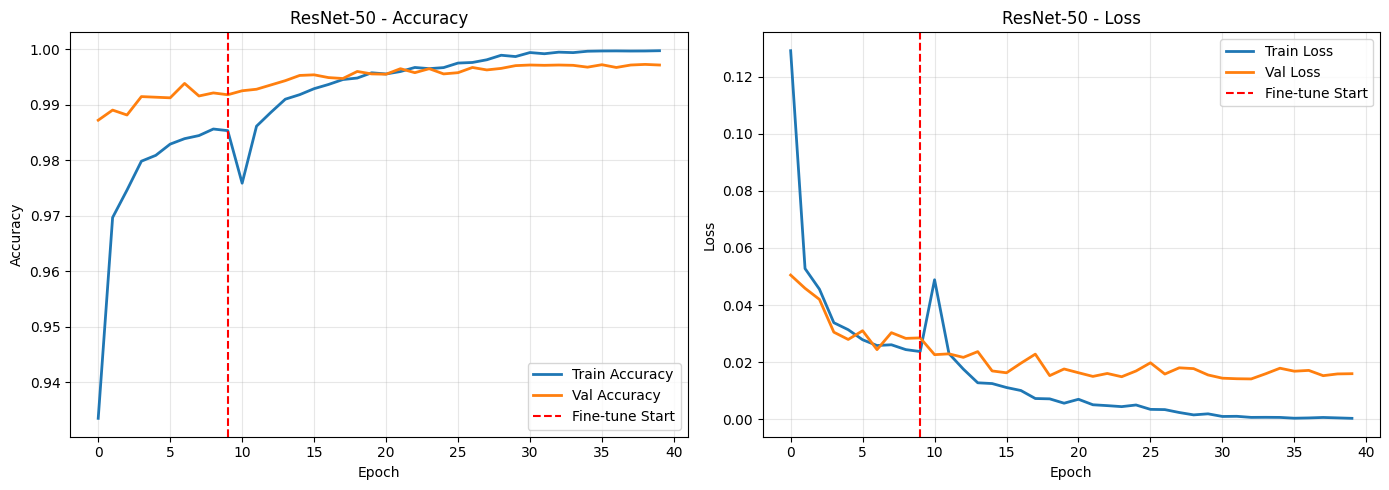


Saved: /content/resnet50_training_history.png

[Best Validation Performance]
  Epoch:    39
  Accuracy: 99.72%


In [ ]:
# ============================================================================
# CELL 13: TRAINING HISTORY PLOTS
# ============================================================================
# Visualizes accuracy and loss curves over training epochs.
# ============================================================================

print("=" * 70)
print("TRAINING HISTORY")
print("=" * 70)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
axes[0].plot(history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0].axvline(x=len(history_phase1.history['loss'])-1, color='r', linestyle='--', label='Fine-tune Start')
axes[0].set_title('ResNet-50 - Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[1].axvline(x=len(history_phase1.history['loss'])-1, color='r', linestyle='--', label='Fine-tune Start')
axes[1].set_title('ResNet-50 - Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/resnet50_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nSaved: /content/resnet50_training_history.png")

# Print best metrics
best_epoch = np.argmax(history['val_accuracy']) + 1
best_val_acc = max(history['val_accuracy'])
print(f"\n[Best Validation Performance]")
print(f"  Epoch:    {best_epoch}")
print(f"  Accuracy: {best_val_acc*100:.2f}%")

In [ ]:
# ============================================================================
# CELL 14: INFERENCE BENCHMARK
# ============================================================================
# Measures inference speed for single image and batch processing.
# ============================================================================

print("=" * 70)
print("INFERENCE BENCHMARK")
print("=" * 70)

# Create test batch
test_batch, _ = next(iter(test_generator))
single_image = test_batch[0:1]

# Warmup
for _ in range(5):
    _ = best_model.predict(single_image, verbose=0)

# Single image inference (100 iterations)
print("\nBenchmarking single image inference...")
times_single = []
for _ in range(100):
    start = time.time()
    _ = best_model.predict(single_image, verbose=0)
    times_single.append((time.time() - start) * 1000)

INFERENCE_TIME_SINGLE = np.mean(times_single)
INFERENCE_STD_SINGLE = np.std(times_single)

# Batch inference (32 images, 20 iterations)
print("Benchmarking batch inference...")
times_batch = []
for _ in range(20):
    start = time.time()
    _ = best_model.predict(test_batch, verbose=0)
    times_batch.append((time.time() - start) * 1000 / len(test_batch))

INFERENCE_TIME_BATCH = np.mean(times_batch)
INFERENCE_STD_BATCH = np.std(times_batch)

print(f"""
[Inference Results]
  Single Image:      {INFERENCE_TIME_SINGLE:.2f} +/- {INFERENCE_STD_SINGLE:.2f} ms
  Batch (per image): {INFERENCE_TIME_BATCH:.2f} +/- {INFERENCE_STD_BATCH:.2f} ms
""")

INFERENCE BENCHMARK

Benchmarking single image inference...
Benchmarking batch inference...

[Inference Results]
  Single Image:      69.18 +/- 2.63 ms
  Batch (per image): 10.18 +/- 24.55 ms



In [18]:
# ============================================================================
# CELL 15: SAVE MODEL AND RESULTS
# ============================================================================
# Saves final model and comprehensive results JSON for comparison.
# ============================================================================

print("=" * 70)
print("SAVING MODEL AND RESULTS")
print("=" * 70)

os.makedirs(DRIVE_MODEL_DIR, exist_ok=True)

# Save model
MODEL_SAVE_PATH = f"{DRIVE_MODEL_DIR}/resnet50_model.keras"
print(f"\nSaving model to: {MODEL_SAVE_PATH}")
best_model.save(MODEL_SAVE_PATH)
print("Model saved.")

model_size_mb = os.path.getsize(MODEL_SAVE_PATH) / (1024 * 1024)

# Compile results
results = {
    "model_name": "ResNet-50",
    "architecture": {
        "type": "Transfer Learning",
        "base_model": "ResNet-50",
        "pretrained_on": "ImageNet",
        "base_layers": len(base_model.layers),
        "fine_tuned_from_layer": fine_tune_from,
        "fine_tuned_layers": len(base_model.layers) - fine_tune_from,
        "dense_units": 256,
        "dropout": 0.3,
        "input_size": list(IMG_SIZE),
        "num_classes": NUM_CLASSES
    },
    "training": {
        "phase1_epochs": len(history_phase1.history['loss']),
        "phase2_epochs": len(history_phase2.history['loss']),
        "total_epochs": len(history['loss']),
        "best_epoch": int(np.argmax(history['val_accuracy']) + 1),
        "training_time_seconds": TRAINING_TIME_SECONDS,
        "batch_size": BATCH_SIZE,
        "image_size": list(IMG_SIZE),
        "used_class_weights": True,
        "augmentation": AUGMENTATION_CONFIG
    },
    "performance": {
        "best_val_accuracy": float(max(history['val_accuracy'])),
        "test_accuracy": float(test_accuracy),
        "test_loss": float(test_loss)
    },
    "per_class_metrics": {
        class_name: {
            "precision": float(report_dict[class_name]["precision"]),
            "recall": float(report_dict[class_name]["recall"]),
            "f1_score": float(report_dict[class_name]["f1-score"]),
            "support": int(report_dict[class_name]["support"])
        }
        for class_name in CLASS_NAMES
    },
    "efficiency": {
        "total_parameters": int(total_params),
        "trainable_parameters": int(trainable_params),
        "model_size_mb": round(model_size_mb, 2),
        "inference_time_single_ms": round(INFERENCE_TIME_SINGLE, 2),
        "inference_time_batch_ms": round(INFERENCE_TIME_BATCH, 2)
    }
}

# Save results JSON
RESULTS_PATH = f"{DRIVE_MODEL_DIR}/resnet50_results.json"
print(f"\nSaving results to: {RESULTS_PATH}")
with open(RESULTS_PATH, 'w') as f:
    json.dump(results, f, indent=2)
print("Results saved.")

# Copy plots
print("\nCopying plots to Drive...")
shutil.copy('/content/resnet50_training_history.png', f"{DRIVE_MODEL_DIR}/resnet50_training_history.png")
shutil.copy('/content/resnet50_confusion_matrix.png', f"{DRIVE_MODEL_DIR}/resnet50_confusion_matrix.png")
print("Plots saved.")

SAVING MODEL AND RESULTS

Saving model to: /content/drive/MyDrive/snapshelf_models_v2/resnet50_model.keras
Model saved.

Saving results to: /content/drive/MyDrive/snapshelf_models_v2/resnet50_results.json
Results saved.

Copying plots to Drive...
Plots saved.


In [17]:
# ============================================================================
# CELL 16: FINAL SUMMARY
# ============================================================================

print("=" * 70)
print("RESNET-50 - FINAL SUMMARY")
print("=" * 70)

print(f"""
MODEL: ResNet-50
--------------------------------------------------
Type:           Transfer Learning
Base Model:     ResNet-50 (ImageNet pretrained)
Fine-tuned:     Top {len(base_model.layers) - fine_tune_from} of {len(base_model.layers)} layers
Head:           GAP + BN + Dropout + Dense(256) + BN + Dropout + Softmax

TRAINING
--------------------------------------------------
Phase 1 Epochs:    {len(history_phase1.history['loss'])} (frozen base)
Phase 2 Epochs:    {len(history_phase2.history['loss'])} (fine-tuning)
Total Epochs:      {len(history['loss'])}
Best Epoch:        {np.argmax(history['val_accuracy']) + 1}
Training Time:     {training_duration}

PERFORMANCE
--------------------------------------------------
Validation Accuracy: {max(history['val_accuracy'])*100:.2f}%
Test Accuracy:       {test_accuracy*100:.2f}%
Test Loss:           {test_loss:.4f}

EFFICIENCY
--------------------------------------------------
Total Parameters:    {total_params:,}
Trainable (Phase 2): {trainable_params:,}
Model Size:          {model_size_mb:.2f} MB
Inference (single):  {INFERENCE_TIME_SINGLE:.2f} ms
Inference (batch):   {INFERENCE_TIME_BATCH:.2f} ms/image

OUTPUT FILES
--------------------------------------------------
Model:   {MODEL_SAVE_PATH}
Results: {RESULTS_PATH}
Plots:   {DRIVE_MODEL_DIR}/resnet50_*.png
""")

print("=" * 70)
print("RESNET-50 TRAINING COMPLETE")
print("=" * 70)

RESNET-50 - FINAL SUMMARY

MODEL: ResNet-50
--------------------------------------------------
Type:           Transfer Learning
Base Model:     ResNet-50 (ImageNet pretrained)
Fine-tuned:     Top 35 of 175 layers
Head:           GAP + BN + Dropout + Dense(256) + BN + Dropout + Softmax

TRAINING
--------------------------------------------------
Phase 1 Epochs:    10 (frozen base)
Phase 2 Epochs:    30 (fine-tuning)
Total Epochs:      40
Best Epoch:        39
Training Time:     10:20:28.334703

PERFORMANCE
--------------------------------------------------
Validation Accuracy: 99.72%
Test Accuracy:       99.76%
Test Loss:           0.0153

EFFICIENCY
--------------------------------------------------
Total Parameters:    24,125,070
Trainable (Phase 2): 15,510,798
Model Size:          211.03 MB
Inference (single):  69.18 ms
Inference (batch):   10.18 ms/image

OUTPUT FILES
--------------------------------------------------
Model:   /content/drive/MyDrive/snapshelf_models_v2/resnet50_mod